In [1]:
from rs_graph.data import (
    load_extended_paper_details_dataset,
    load_basic_repos_dataset,
)
import numpy as np

np.random.seed(42)

repos = load_basic_repos_dataset()
papers = load_extended_paper_details_dataset().sample(500)

# Get repo name from repos dataset and merge with papers on doi
papers = papers.merge(repos[["repo", "doi"]], on="doi")

# Format into ready for training
papers = papers.drop(columns=["url", "authors", "citation_count"])

# Drop duplicates
papers = papers.drop_duplicates(subset=["doi"])
papers.sample(3)

,corpus_id,doi,title,abstract,repo
258,56487034,10.21105/joss.01071,Shenfun: High performance spectral Galerkin co...,None,https://github.com/spectralDNS/shenfun
363,195755493,10.21105/joss.01410,Stripy: A Python module for (constrained) tria...,The triangulation of scattered points is a com...,https://github.com/underworldcode/stripy
9,53238338,10.21105/joss.00892,YAD: A Learning-based Inductive Logic Programm...,Inductive logic learning is considered as one ...,https://github.com/hamedmx/YAD-ILP-Tool


In [2]:
# for each repo, get the reademe (if it exists) and the description.
from dotenv import load_dotenv
from ghapi.all import GhApi
from rs_graph.data.enrichment.github import get_repo_parts_from_url
import base64

load_dotenv()

api = GhApi()

def get_repo_readme(repo: str) -> str | None:
    repo_parts = get_repo_parts_from_url(repo)
    try:
        b64_encoded_readme = api.repos.get_readme(
                owner=repo_parts.owner,
                repo=repo_parts.repo,
            )["content"]
        
        return base64.b64decode(b64_encoded_readme).decode("utf-8")
    except:
        return None

In [3]:
# Get the READMEs and then then embeddings for each README
from tqdm import tqdm
import time

readmes = []
for repo in tqdm(papers["repo"], total=len(papers)):
    readmes.append(get_repo_readme(repo))
    time.sleep(0.85)

# Attach to papers
papers["readme"] = readmes

# Drop nulls
papers = papers.dropna(subset=["readme"])
papers.shape

100%|██████████| 498/498 [09:28<00:00,  1.14s/it]


(452, 6)

In [4]:
# Get the embeddings for each README
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("all-mpnet-base-v2")

readme_embeddings = model.encode(papers["readme"].tolist())
readme_embeddings.shape

(452, 768)

In [5]:
# Attach back to dataframe
papers["readme_embedding"] = [np.array(vec) for vec in readme_embeddings.tolist()]
papers.sample(3)

,corpus_id,doi,title,abstract,repo,readme,readme_embedding
391,226319283,10.21105/joss.02166,COINSTAC: Collaborative Informatics and Neuroi...,Central to the field of neuroimaging is the de...,https://github.com/MRN-Code/coinstac,# Collaborative Informatics and Neuroimaging S...,"[-0.0075867995619773865, 0.04865483194589615, ..."
483,251208162,10.21105/joss.04335,Archeofrag: an R package for Refitting and Spa...,Distinguishing between spatial entities is fun...,https://github.com/sebastien-plutniak/archeofrag,\n# Archeofrag\n\nAn R package for refitting a...,"[-0.041188787668943405, -0.01029176265001297, ..."
202,244592537,10.21105/joss.03679,"Devicely: A Python package for reading, timesh...",Wearable devices can track a multitude of para...,https://github.com/hpi-dhc/devicely/,[![pyOpenSci](https://tinyurl.com/y22nb8up)](h...,"[-0.0002808483550325036, -0.04778539389371872,..."


In [6]:
# Get the embeddings for each paper abstract
# or if the abstract is None, use the title
papers["paper_text"] = papers["abstract"].fillna(papers["title"])

# Drop any nulls
papers = papers.dropna(subset=["paper_text"])

# Get the embeddings for each paper abstract
paper_embeddings = model.encode(papers["paper_text"].tolist())

# Drop paper_text col
papers = papers.drop(columns=["paper_text"])

# Attach back to dataframe
papers["paper_embedding"] = [np.array(vec) for vec in paper_embeddings.tolist()]
papers.sample(3)

,corpus_id,doi,title,abstract,repo,readme,readme_embedding,paper_embedding
341,240140407,10.21105/joss.00924,graynet: single-subject morphometric networks ...,None,https://github.com/raamana/graynet,# graynet\n\n[![DOI](http://joss.theoj.org/pap...,"[-0.031660307198762894, 0.03191467747092247, -...","[-0.07226675748825073, 0.09770593047142029, -0..."
283,198335065,10.1016/j.softx.2019.100257,ELEMENTS: A high-order finite element library ...,None,https://github.com/laristra/libristra,The Ristra Library\n==================\n\nThe ...,"[-0.05260487273335457, -0.004707955289632082, ...","[-0.06790685653686523, 0.046562545001506805, -..."
301,229345064,10.1016/j.softx.2020.100633,AnsibleMetrics: A Python library for measuring...,None,https://github.com/radon-h2020/radon-ansible-m...,"<p align=""center"" width=""100%"">\n <img src=...","[-0.015308300964534283, -0.05369460955262184, ...","[-0.08103445917367935, 0.0030725165270268917, ..."


In [7]:
import pandas as pd

# Mark all current columns as label = match
train_ready = papers.copy(deep=True)
train_ready["label"] = "match"

# Construct negative random samples
negative_samples = []
for _, row in tqdm(train_ready.iterrows(), total=len(train_ready)):
    # this row will be the paper
    # draw three other random rows and use the repo information
    # from them as the negative
    for _ in range(1):
        other_row = train_ready.sample(1).iloc[0]

        # resample if the repo is the same
        while other_row["repo"] == row["repo"]:
            other_row = train_ready.sample(1).iloc[0]
        
        # Append the negative example row
        negative_samples.append(
            {
                "corpus_id": row.corpus_id,
                "doi": row.doi,
                "title": row.title,
                "abstract": row.abstract,
                "paper_embedding": row.paper_embedding,
                "repo": other_row.repo,
                "readme": other_row.readme,
                "readme_embedding": other_row.readme_embedding,
                "label": "no_match",
            }
        )

# Construct the negative samples dataframe
negative_samples = pd.DataFrame(negative_samples)

# Combine the two dataframes
train_ready = pd.concat([train_ready, negative_samples])
train_ready.sample(3)

100%|██████████| 452/452 [00:00<00:00, 3430.33it/s]


,corpus_id,doi,title,abstract,repo,readme,readme_embedding,paper_embedding,label
256,259318367,10.21105/joss.05256,gemlog: Data Conversion for the Open-Source Ge...,Infrasound (low-frequency pressure waves in ai...,https://github.com/ajakef/gemlog,# [Installation](https://github.com/ajakef/gem...,"[0.02852459065616131, 0.05288788303732872, 0.0...","[-0.02141496352851391, -0.007889585569500923, ...",match
406,261469974,10.1016/j.softx.2023.101511,GOMap: A Python-developed GIS opportunity mapp...,None,https://github.com/GOMC-WSU/GOMC,# GOMC - GPU Optimized Monte Carlo\n\nCurrent ...,"[-0.03867769241333008, -0.0361463762819767, -0...","[-0.014050190337002277, 0.01229638047516346, -...",no_match
303,86503010,10.1016/j.softx.2017.12.001,Q6: A comprehensive toolkit for empirical vale...,None,https://github.com/maxrousseau/pfla,"<p align=""center""><a>\n<img title=""pfla logo"" ...","[0.023480914533138275, -0.030531639233231544, ...","[0.009962964802980423, 0.007279368117451668, -...",no_match


In [8]:
# Create interaction embeddings and train logistic regression CV
train_ready["interaction_embedding"] = train_ready.apply(
    lambda row: row.paper_embedding * row.readme_embedding,
    axis=1,
)

Precision: 0.9102564102564102
Recall: 0.7802197802197802
F1: 0.8402366863905325


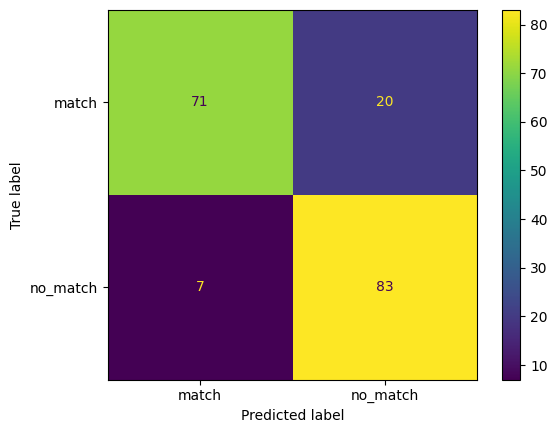

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import precision_recall_fscore_support, ConfusionMatrixDisplay

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    train_ready["interaction_embedding"].tolist(),
    train_ready["label"].tolist(),
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=train_ready["label"].tolist(),
)

# Train model
clf = LogisticRegressionCV(
    cv=10,
    max_iter=1000,
    random_state=42,
).fit(X_train, y_train)

# Evaluate model
y_pred = clf.predict(X_test)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test,
    y_pred,
    average="binary",
    pos_label="match",
)

# Print results
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

# Plot confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

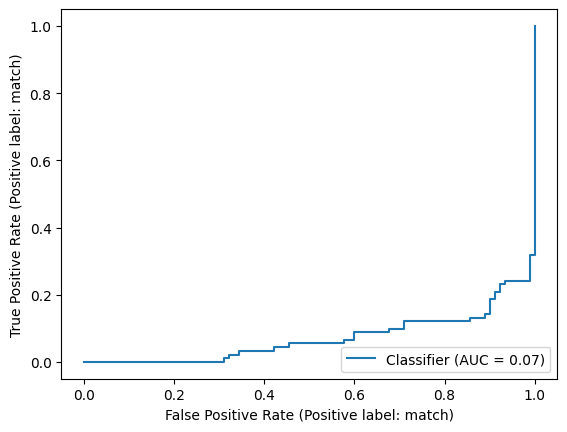

In [12]:
from sklearn.metrics import RocCurveDisplay

y_pred_conf = clf.decision_function(X_test)
RocCurveDisplay.from_predictions(y_test, y_pred_conf, pos_label="match")